In [ ]:
import random
import sys, pdb
import site, os
import collections
import numpy as np
import igraph as ig
from datetime import datetime
import time
sys.path.append(os.path.abspath("../auxiliary_scripts/"))
from input_module import *
from output_module import *
from tnn import generate_new_transmissibilities_mask
from main_aux import *
from para_settings import para_setting
from IPython.core.debugger import set_trace

In [2]:
# Exp30 paras
paras = para_setting()
paras.T = [0.6, 0.8]
paras.tm1 = [0.4, 1] # 0.3: introvert 0.6: extrovert
paras.tm2 = [0.5, 1] # 0.3: hard to convince 0.6: easy to believe
paras.kmax = [40, 40] 
paras.ns = [9, 1]
paras.mind = [1, 3]
paras.maxd = [3, 3]
paras.m = [0.5, 0.5] # two types of nodes
paras.alpha=0.6
paras.n = 5
# 4 nodes in the primary graph
paras.e = 1
paras.cp = 1
paras.nc= 500
paras.change = 0
paras.msg = 'debug_PGF_P'

paras_check(paras)
mean_degree_lists = get_mean_degree_list(paras)
M = len(paras.m)
k_maxs, T_lists = resolve_paras(paras)
kmax = max(k_maxs) # Note: we actually sum from 0 to kmax-1 due to np.arange
Tb = np.array(T_lists[0]) # Transmissibility on the blue graph
Tr = np.array(T_lists[1]) # Transmissibility on the red graph
m = np.array(paras.m)
alpha = paras.alpha

mean_degree_lists

[(1.0, 3.0),
 (1.25, 3.0),
 (1.5, 3.0),
 (1.75, 3.0),
 (2.0, 3.0),
 (2.25, 3.0),
 (2.5, 3.0),
 (2.75, 3.0),
 (3.0, 3.0)]

In [3]:
mean_degree = mean_degree_lists[-1]

In [4]:
mean_degree

(3.0, 3.0)

In [5]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def div(x, y):
    if y == 0:
        return 0
    else:
        return x*1.0/y

def create_network(mean_degree, num_nodes):
    degree_sequence = np.random.poisson(mean_degree, num_nodes)
    while (np.sum(degree_sequence) % 2 !=0):
        degree_sequence = np.random.poisson(mean_degree, num_nodes)
    return ig.Graph.Degree_Sequence(list(degree_sequence)).simplify()
    

def get_accumulated_mask_probs(mask_probs,):
    '''
    Input: 
    mask_probs: A list of mask probabilities, where sum(mask_probs) = 1. 
    Output: 
    accumulated_mask_probs: An length 1 interval with each segment having the length of each ele in mask prob
    e.g. 
    mask_probs = [0.3, 0.2, 0.1, 0.4]
    accumulated_mask_probs = [0, 0.3, 0.5, 0.6, 1]
    '''
    accumulated_mask_probs = [0]
    
    for idx, m in enumerate(mask_probs):
        accumulated_mask_probs.append(m + accumulated_mask_probs[idx])
    
    return accumulated_mask_probs

def get_node_status(mask_roll_dice, accumulated_mask_probs):
    '''
    Input:  accumulated_mask_probs
    Output: int, corresponding to the idx of the mask_prob, 
            the maks wearing type of a single node.
    '''
    
    mask_status = []
    for roll_dice in mask_roll_dice:
        distance = roll_dice - np.array(accumulated_mask_probs)

        mask_type = -1
        for idx, dis in enumerate(distance):
            if dis >= 0 and distance[idx + 1] < 0:
                mask_type = idx
                break
        mask_status.append(mask_type)
        
    return mask_status

def get_mask_status(mask_probs, num_nodes):
    '''
    Input:  
    mask_prob: A list of mask probabilities(len(mask_prob = num_mask_types)
    num_nodes: Graph size
    Output: 
    mask_status: A list of mask wearing states for each node in the graph.
    '''
    accumulated_mask_probs = get_accumulated_mask_probs(mask_probs,)
    mask_roll_dice = np.random.rand(num_nodes)
    mask_status = get_node_status(mask_roll_dice, accumulated_mask_probs)
        
    return mask_status

def get_seed(start_strain, num_nodes, mask_status, num_strain):
    if start_strain < 0 or start_strain >= num_strain:
        print("sim-ray.py: start_strain out of index!")
        assert False
        
    seed = int(np.random.randint(0, num_nodes - 1))   
    strain_list = [set() for i in range(num_strain)]
    while mask_status[seed] != start_strain:
        seed = int(np.random.randint(0, num_nodes - 1))
    strain_list[start_strain] = set([seed])
    
    return seed, strain_list
    





primary_net node set: [igraph.Vertex(<igraph.Graph object at 0x7f4ad6f62d60>, 0, {}), igraph.Vertex(<igraph.Graph object at 0x7f4ad6f62d60>, 1, {}), igraph.Vertex(<igraph.Graph object at 0x7f4ad6f62d60>, 2, {}), igraph.Vertex(<igraph.Graph object at 0x7f4ad6f62d60>, 3, {}), igraph.Vertex(<igraph.Graph object at 0x7f4ad6f62d60>, 4, {})]
primary_net: IGRAPH U--- 5 6 --
+ attr: color (e)
+ edges:
0--1 0--4 1--2 1--4 2--3 3--4


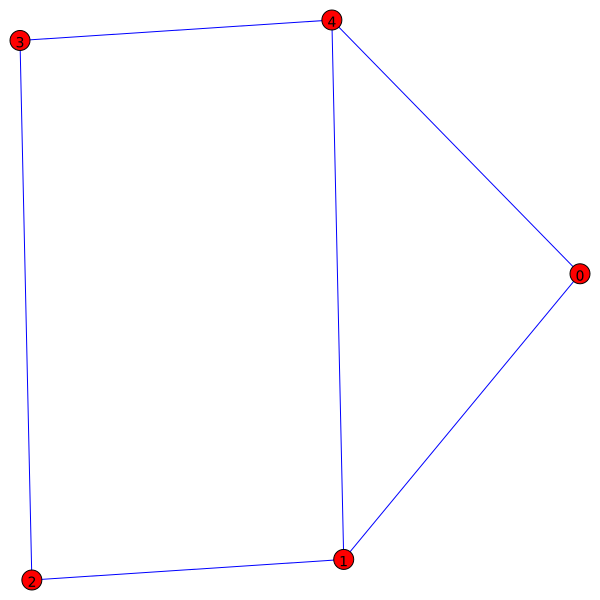

In [6]:
primary_net = create_network(mean_degree[0], paras.n)
primary_net.es['color'] = 'blue'

print('primary_net node set:',list(primary_net.vs()))
print('primary_net:', primary_net)

ig.plot(primary_net, vertex_label=primary_net.vs.indices, edge_color='blue')

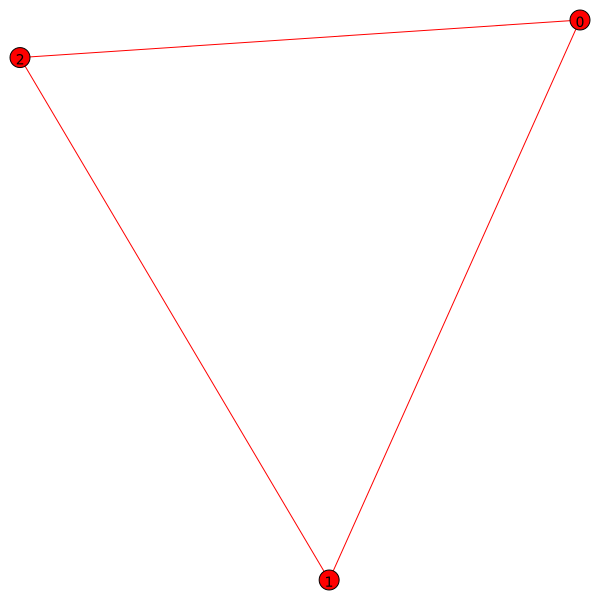

In [7]:
n_second = int(paras.alpha * paras.n)
second_net = create_network(mean_degree[1], n_second)
second_net.es['color'] = 'red'
ig.plot(second_net, vertex_label=second_net.vs.indices, edge_color=second_net.es['color'])

In [8]:
for edge in second_net.es:
    primary_net.add_edges([(edge.source, edge.target)], attributes={'color': edge['color']})

In [9]:
print(primary_net)

IGRAPH U--- 5 9 --
+ attr: color (e)
+ edges:
0 -- 1 1 2 4     2 -- 0 1 1 3     4 -- 0 1 3
1 -- 0 0 2 2 4   3 -- 2 4


In [10]:
for edge in primary_net.es():
    print('eid: %d, (%d, %d), %s'%(edge.index, edge.source, edge.target, edge['color']))

eid: 0, (0, 1), blue
eid: 1, (0, 4), blue
eid: 2, (1, 2), blue
eid: 3, (1, 4), blue
eid: 4, (2, 3), blue
eid: 5, (3, 4), blue
eid: 6, (0, 1), red
eid: 7, (0, 2), red
eid: 8, (1, 2), red


In [11]:
color_set = ['green', 'yellow', 'pink', 'purple', 'blue']

In [12]:
T_list = T_lists 
mask_prob = paras.m
start_strain = 0
g = primary_net # g becomes union_net

node_set = set(g.vs.indices)
num_nodes = len(node_set)
num_mask_types = len(T_list[0]) # num_mask_types
mask_status = get_mask_status(mask_prob, num_nodes, )
g.vs['mask_status'] = mask_status
g.vs['color'] = [color_set[node['mask_status']] for node in g.vs]

print(g.vs['mask_status'])

[1, 1, 1, 0, 0]


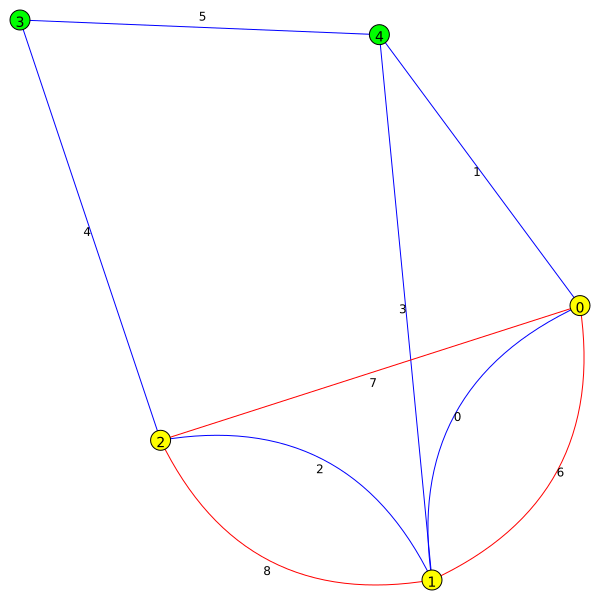

In [13]:
ig.plot(g, vertex_label=g.vs.indices, edge_color=g.es['color'], edge_label=g.es.indices)

In [14]:
seed, strain_list = get_seed(1, num_nodes, mask_status, num_mask_types) 
print('seed:', seed)
print('strain_list:', strain_list)

seed: 1
strain_list: [set(), {1}]


In [15]:
def infected_rule(infected_neighbors_dict, T_list, susceptible_nodes, num_strain, mask_prob, mask_status, g):
    new_nodes_list = [set() for i in range(num_strain)]
    
    if len(infected_neighbors_dict.keys()) != 0:
        
        for susceptible_node in infected_neighbors_dict:
            trial_list = infected_neighbors_dict[susceptible_node] # All of his infected neighbors
            random.shuffle(trial_list)
            infected = False
            for infected_neighbor, infected_neighbor_type in trial_list:
                if infected:
                    break
                strain_type_idx = mask_status[susceptible_node]
                
                for e in g.es.select(_source=infected_neighbor, _target=susceptible_node):
                    if e['color'] == 'blue':
                        T = T_list[0][infected_neighbor_type][mask_status[susceptible_node]]
                    else:
                        T = T_list[1][infected_neighbor_type][mask_status[susceptible_node]]

                    if random.random() < T: # susceptible node is infected
                        print('Node %d is infected by node %d with an %s edge, edge idx %d!!'%(susceptible_node, 
                                                                                  infected_neighbor, 
                                                                                               e['color'], e.index))
                        susceptible_nodes.remove(susceptible_node)

                        new_nodes_list[strain_type_idx].add(susceptible_node)
                        infected = True
                        break
                    else:
                        print('Node %d is NOT infected by node %d with an %s edge, edge idx %d!!'%(susceptible_node, 
                                                                                  infected_neighbor, 
                                                                                               e['color'], e.index))
                        
    return new_nodes_list, susceptible_nodes

In [16]:
susceptible_nodes = node_set
for strain_set in strain_list:
    susceptible_nodes = susceptible_nodes.difference(strain_set)
new_nodes_list = strain_list # level L - 1

print('starting strain_list:', strain_list)
while(sum([len(new_nodes) for new_nodes in new_nodes_list])):
    neighbor_dict = collections.defaultdict(list) # susceptible nodes in level L, its parents are in the list

    for strain_type, strain_set in enumerate(new_nodes_list): # string type == 0: wear mask
        strain_neighbors_list = []

        for infected_node in strain_set:
            strain_neighbors_list = g.neighbors(infected_node)
            for susceptible_node in strain_neighbors_list:
                if susceptible_node not in susceptible_nodes: continue
                neighbor_dict[susceptible_node].append((infected_node, strain_type))

    new_nodes_list, susceptible_nodes = infected_rule(neighbor_dict, T_list, susceptible_nodes, num_mask_types, mask_prob, mask_status, g) # Get next level
    
    strain_list = [strain_list[s_idx].union(s) for s_idx, s in enumerate(new_nodes_list)]
    print('strain_list:', strain_list)
#     set_trace()
    

# num_infected = sum([len(s) for s in strain_list])
# num_infected_list = map(len, strain_list)


starting strain_list: [set(), {1}]
Node 0 is NOT infected by node 1 with an blue edge, edge idx 0!!
Node 0 is infected by node 1 with an red edge, edge idx 6!!
Node 2 is infected by node 1 with an blue edge, edge idx 2!!
Node 4 is NOT infected by node 1 with an blue edge, edge idx 3!!
strain_list: [set(), {0, 1, 2}]
Node 4 is NOT infected by node 0 with an blue edge, edge idx 1!!
Node 3 is NOT infected by node 2 with an blue edge, edge idx 4!!
strain_list: [set(), {0, 1, 2}]


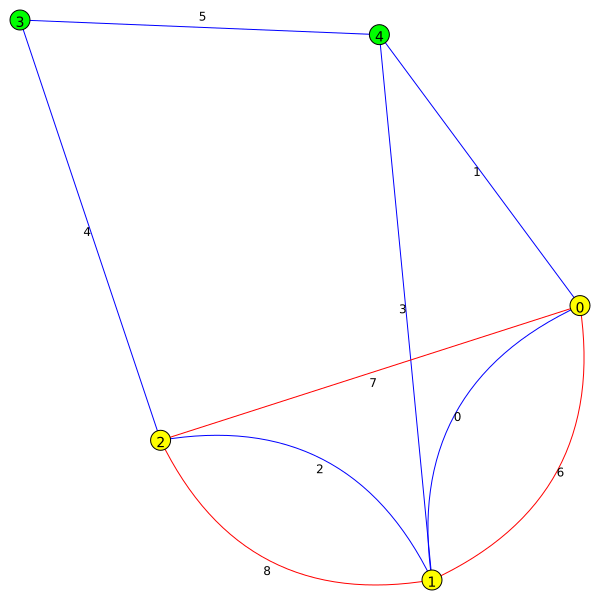

In [17]:
ig.plot(g, vertex_label=g.vs.indices, edge_color=g.es['color'], edge_label=g.es.indices)

In [18]:
strain_list

[set(), {0, 1, 2}]